<a href="https://colab.research.google.com/github/moamitay/LMM/blob/main/Bert_cola_Hugging_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
#from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

#import tokenization


import os

In [ ]:
!unzip drive/MyDrive/data_sets/Bert_Cola/cola_public_1.1.zip   -d drive/MyDrive/data_sets/Bert_Cola/

Archive:  drive/MyDrive/data_sets/Bert_Cola/cola_public_1.1.zip
   creating: drive/MyDrive/data_sets/Bert_Cola/cola_public/
  inflating: drive/MyDrive/data_sets/Bert_Cola/cola_public/README  
   creating: drive/MyDrive/data_sets/Bert_Cola/cola_public/tokenized/
  inflating: drive/MyDrive/data_sets/Bert_Cola/cola_public/tokenized/in_domain_dev.tsv  
  inflating: drive/MyDrive/data_sets/Bert_Cola/cola_public/tokenized/in_domain_train.tsv  
  inflating: drive/MyDrive/data_sets/Bert_Cola/cola_public/tokenized/out_of_domain_dev.tsv  
   creating: drive/MyDrive/data_sets/Bert_Cola/cola_public/raw/
  inflating: drive/MyDrive/data_sets/Bert_Cola/cola_public/raw/in_domain_dev.tsv  
  inflating: drive/MyDrive/data_sets/Bert_Cola/cola_public/raw/in_domain_train.tsv  
  inflating: drive/MyDrive/data_sets/Bert_Cola/cola_public/raw/out_of_domain_dev.tsv  


8551
1    6023
0    2528
Name: label, dtype: int64


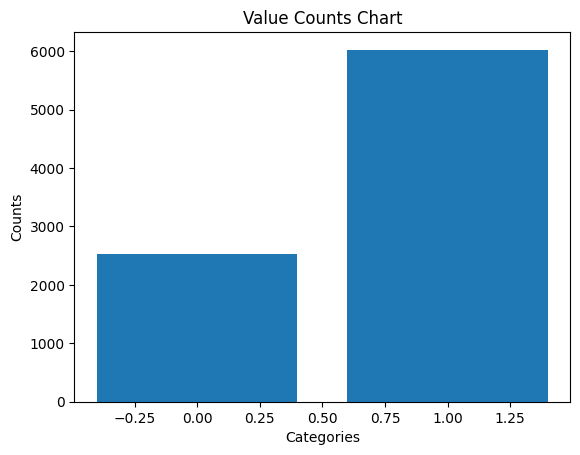

In [ ]:
from sklearn.utils import shuffle
df = pd.read_csv("drive/MyDrive/data_sets/Bert_Cola/cola_public/tokenized/in_domain_train.tsv",sep='\t',names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = shuffle(df)
df_2cols = df[[ 'label', 'sentence']]
sentences = df.sentence.values
labels = df.label.values
print(len(sentences))
print(df.label.value_counts())

import matplotlib.pyplot as plt
a=df.label.value_counts()

plt.bar(a.index, a.values)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Value Counts Chart')
plt.show()

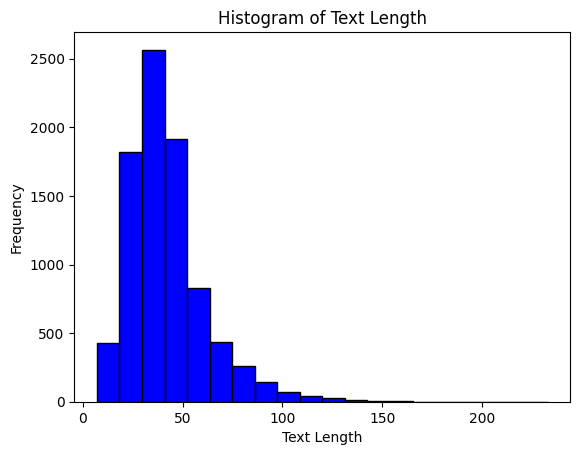

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame creation (replace this with your actual DataFrame)


# Add a new column 'text_length' containing the length of each text
df['text_length'] = df['sentence'].apply(len)

# Create a histogram
plt.hist(df['text_length'], bins=20, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Histogram of Text Length')

# Show the plot
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_2cols, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [ ]:
print(train[0:10])



      label                                           sentence
5285      1                          how likely to win is he ?
4625      0     they believe stephen to be easy to annoy ben .
8120      0  who did that plato loved prove to be his undoi...
471       1       i believed these students all to like john .
3455      1                the student was hoping for a tool .
2168      0                                     the door hit .
2046      0                fred offered the ball under molly .
6043      1                            i wanted him to leave .
3476      0                       little clue could be found .
42        0                      they made him to exhaustion .


In [ ]:
pip install Datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd

train, test, val = pd.DataFrame(train),pd.DataFrame(test),pd.DataFrame(val)

ds_dict = {'train' : Dataset.from_pandas(train),
           'val' : Dataset.from_pandas(val),
           'test' : Dataset.from_pandas(test)}

ds = DatasetDict(ds_dict)

#dataset.train_test_split(test_size=0.1)

In [ ]:
ds['train'][6]

{'label': 0,
 'sentence': 'fred offered the ball under molly .',
 '__index_level_0__': 2046}

In [ ]:
ds = ds.remove_columns("__index_level_0__")
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'sentence'],
        num_rows: 5472
    })
    val: Dataset({
        features: ['label', 'sentence'],
        num_rows: 1368
    })
    test: Dataset({
        features: ['label', 'sentence'],
        num_rows: 1711
    })
})

In [ ]:
pip install transformers

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)


tokenized_datasets = ds.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32,
)

tf_validation_dataset = tokenized_datasets["val"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=32,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=32,
)

Map:   0%|          | 0/5472 [00:00<?, ? examples/s]

Map:   0%|          | 0/1368 [00:00<?, ? examples/s]

Map:   0%|          | 0/1711 [00:00<?, ? examples/s]

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# dont run this cell this is for check

from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
)

855/855 [==============================] - 153s 127ms/step - loss: 0.6567 - accuracy: 0.6693 - val_loss: 0.6049 - val_accuracy: 0.7072


In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

batch_size = 32
num_epochs = 5
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=5)

Epoch 1/5
171/171 [==============================] - 107s 255ms/step - loss: 0.5121 - accuracy: 0.7527 - val_loss: 0.4257 - val_accuracy: 0.8012
Epoch 2/5
171/171 [==============================] - 38s 223ms/step - loss: 0.2733 - accuracy: 0.8942 - val_loss: 0.4678 - val_accuracy: 0.8297
Epoch 3/5
171/171 [==============================] - 34s 201ms/step - loss: 0.1186 - accuracy: 0.9614 - val_loss: 0.5251 - val_accuracy: 0.8209
Epoch 4/5
171/171 [==============================] - 37s 219ms/step - loss: 0.0697 - accuracy: 0.9768 - val_loss: 0.6113 - val_accuracy: 0.8297
Epoch 5/5
171/171 [==============================] - 37s 214ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.7177 - val_accuracy: 0.8341


In [ ]:
preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

54/54 [==============================] - 5s 92ms/step
(1711, 2) (1711,)


In [ ]:
#class_preds

from sklearn.metrics import accuracy_score, f1_score

print (accuracy_score(test.label, class_preds))
print (f1_score(test.label, class_preds))

0.8246639392168322
0.8810467882632831


Max length:  47
